# Preprocessing

In [62]:
import os
import sys
import pandas as pd
from copy import copy

data_path = os.path.join(os.getcwd(), '../data')

In [63]:
df = pd.read_csv(os.path.join(data_path, 'data.csv'), index_col='Municipality')

In [66]:
df.head()

,territory__surface_area,territory__altitude,territory__longitude,territory__latitude,territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,population_density_of_population_surface_area_surface_area,population_density_of_population_density_density,population_population_by_sex_total,population_population_by_age_groups_from_0_to_14_years,...,main_aggregates_gross_value_added_2019_hostelry,main_aggregates_gross_value_added_2019_financial_and_insurance_activities,main_aggregates_gross_value_added_2019_real_estate_technical_and_adm_activities,main_aggregates_gross_value_added_2019_public_administration_and_other_services,main_aggregates_gross_value_added_2019_total.2,quality_of_life_useful_surface_area_of_dwellings_up_to_60_m,economic_sectors_head_of_livestock_main,economic_sectors_cultivated_land_main,population_population_by_sex_main,culture_sports_facilities_main
Municipality,,,,,,,,,,,,,,,,,,,,,
Alt Camp,538.00,NaN,NaN,NaN,NaN,NaN,538.00,83.7,45045,6832,...,90.8,24.0,192.4,161.2,663.2,NaN,avian,vines,men,other_facilities
Alt Empordà,1357.54,NaN,NaN,NaN,NaN,NaN,1357.54,105.9,143762,22354,...,436.9,87.6,610.4,617.1,2481.0,7313.0,avian,herbaceous_crops,men,other_facilities
Alt Penedès,592.69,NaN,NaN,NaN,NaN,NaN,592.69,185.9,110172,18037,...,103.4,98.7,452.6,355.0,1623.1,NaN,avian,vines,women,other_facilities
Alt Urgell,1447.46,NaN,NaN,NaN,NaN,NaN,1447.46,14.1,20453,2667,...,40.1,10.0,82.2,112.6,346.3,NaN,avian,herbaceous_crops,women,other_facilities
Alta Ribagorça,426.86,NaN,NaN,NaN,NaN,NaN,426.86,9.2,3945,495,...,20.6,3.2,14.0,20.7,70.6,NaN,ovine,herbaceous_crops,men,other_facilities


## Duplicated Columns

In [67]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicated_columns = getDuplicateColumns(df)

In [68]:
df.drop(columns=duplicated_columns, inplace=True)

Most indicators are given as a population count, so such indicators need to be scaled to the municipality population in order to be comparable.

In [69]:
not_div_cols = list(df.filter(regex=r'catalan|density|education|per_capita|municipal_waste|^(?!.*surface).*territory.*$|(?=.*growth)(?=.*average)|turnout|rate').columns)

In [70]:
df['population_population_by_sex_total'].isna().sum()

0

In [71]:
not_div_cols.append('population_population_by_sex_total')
cols = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').columns
df[cols] = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').div(df['population_population_by_sex_total'], axis=0)

Since the label is quite important we will normalize it using data from the same year it was measured, 2011:

In [72]:
aux = pd.read_csv(os.path.join(data_path, 'pmh446mun.csv'))
aux = aux[aux['year'] == 2011]
aux = aux[aux['sex'] == 'total']
print(aux.shape)
aux.head()

(948, 6)


,year,municipalities,sex,concept,status,value
36974,2011,Abella de la Conca,total,population,NaN,181.0
36977,2011,Abrera,total,population,NaN,11611.0
36980,2011,Àger,total,population,NaN,590.0
36983,2011,Agramunt,total,population,NaN,5653.0
36986,2011,Aguilar de Segarra,total,population,NaN,245.0


In [78]:
df.reset_index(inplace=True)
df.head()

,Municipality,territory__surface_area,territory__altitude,territory__longitude,territory__latitude,territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,population_density_of_population_density_density,population_population_by_sex_total,population_population_by_age_groups_from_0_to_14_years,...,main_aggregates_gross_value_added_2019_hostelry,main_aggregates_gross_value_added_2019_financial_and_insurance_activities,main_aggregates_gross_value_added_2019_real_estate_technical_and_adm_activities,main_aggregates_gross_value_added_2019_public_administration_and_other_services,main_aggregates_gross_value_added_2019_total.2,quality_of_life_useful_surface_area_of_dwellings_up_to_60_m,economic_sectors_head_of_livestock_main,economic_sectors_cultivated_land_main,population_population_by_sex_main,culture_sports_facilities_main
0,Alt Camp,0.011944,NaN,NaN,NaN,NaN,NaN,83.7,45045,0.151671,...,0.002016,0.000533,0.004271,0.003579,0.014723,NaN,avian,vines,men,other_facilities
1,Alt Empordà,0.009443,NaN,NaN,NaN,NaN,NaN,105.9,143762,0.155493,...,0.003039,0.000609,0.004246,0.004293,0.017258,0.050869,avian,herbaceous_crops,men,other_facilities
2,Alt Penedès,0.005380,NaN,NaN,NaN,NaN,NaN,185.9,110172,0.163717,...,0.000939,0.000896,0.004108,0.003222,0.014732,NaN,avian,vines,women,other_facilities
3,Alt Urgell,0.070770,NaN,NaN,NaN,NaN,NaN,14.1,20453,0.130397,...,0.001961,0.000489,0.004019,0.005505,0.016932,NaN,avian,herbaceous_crops,women,other_facilities
4,Alta Ribagorça,0.108203,NaN,NaN,NaN,NaN,NaN,9.2,3945,0.125475,...,0.005222,0.000811,0.003549,0.005247,0.017896,NaN,ovine,herbaceous_crops,men,other_facilities


In [80]:
d = pd.merge(aux, df, left_on='municipalities', right_on='Municipality')

In [88]:
d = d[d['Municipality'] != 'Catalunya'].drop(columns=['year', 'municipalities', 'sex', 'concept', 'status']).set_index('Municipality')

In [97]:
d['label'] = d['culture_knowledge_of_catalan_speak']/d['value']

In [96]:
d.filter(like='catalan')

,culture_knowledge_of_catalan_understand,culture_knowledge_of_catalan_speak,culture_knowledge_of_catalan_read,culture_knowledge_of_catalan_write,culture_knowledge_of_catalan_total,culture_knowledge_of_catalan_do_not_understand
Municipality,,,,,,
Abella de la Conca,169.0,164.0,161.0,107.0,169.0,0.0
Abrera,10796.0,7703.0,8748.0,6099.0,11351.0,556.0
Àger,508.0,426.0,451.0,325.0,514.0,NaN
Agramunt,5344.0,4472.0,4582.0,3692.0,5416.0,NaN
Aguilar de Segarra,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Vinaixa,559.0,506.0,523.0,337.0,559.0,0.0
Vinebre,455.0,371.0,367.0,267.0,471.0,NaN
Vinyols i els Arcs,1689.0,1309.0,1329.0,1095.0,1824.0,135.0


<AxesSubplot:xlabel='label', ylabel='Count'>

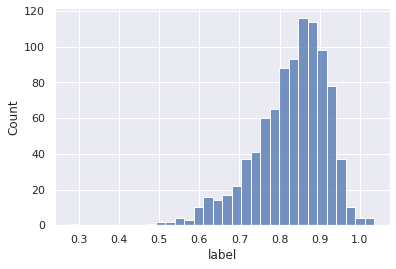

In [98]:
sns.histplot(d['label'])

In [84]:
for i in range(len(d)):
    print(d.iloc[i,1])

Abella de la Conca
Abrera
Àger
Agramunt
Aguilar de Segarra
Agullana
Aiguafreda
Aiguamúrcia
Aiguaviva
Aitona
Alamús, els
Alàs i Cerc
Albagés, l'
Albanyà
Albatàrrec
Albesa
Albi, l'
Albinyana
Albiol, l'
Albons
Alcanar
Alcanó
Alcarràs
Alcoletge
Alcover
Aldea, l'
Aldover
Aleixar, l'
Alella
Alfara de Carles
Alfarràs
Alfés
Alforja
Algerri
Alguaire
Alins
Alió
Almacelles
Almatret
Almenar
Almoster
Alòs de Balaguer
Alp
Alpens
Alpicat
Alt Àneu
Altafulla
Amer
Ametlla de Mar, l'
Ametlla del Vallès, l'
Ampolla, l'
Amposta
Anglès
Anglesola
Arbeca
Arboç, l'
Arbolí
Arbúcies
Arenys de Mar
Arenys de Munt
Argelaguer
Argençola
Argentera, l'
Argentona
Armentera, l'
Arnes
Arres
Arsèguel
Artés
Artesa de Lleida
Artesa de Segre
Ascó
Aspa
Avellanes i Santa Linya, les
Avià
Avinyó
Avinyonet de Puigventós
Avinyonet del Penedès
Badalona
Badia del Vallès
Bagà
Baix Pallars
Balaguer
Balenyà
Balsareny
Banyeres del Penedès
Banyoles
Barbens
Barberà de la Conca
Barberà del Vallès
Barcelona
Baronia de Rialb, la
Bàscara
Basse

## Numerical Missing Values

In [12]:
percent_missing = df.isnull().sum() / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}).reset_index(drop=True).iloc[1:, :]
missing_value_df_copy = copy(missing_value_df)
missing_value_df.describe()

,percent_missing
count,205.000000
mean,0.231372
std,0.343014
min,0.000000
25%,0.000000
50%,0.002020
75%,0.495960
max,0.986869


In [13]:
missing_value_df.head()

,column_name,percent_missing
1,territory__altitude,0.043434
2,territory__longitude,0.043434
3,territory__latitude,0.043434
4,territory__geographic_indicators_utm_coordinat...,0.043434
5,territory__geographic_indicators_utm_coordinat...,0.043434


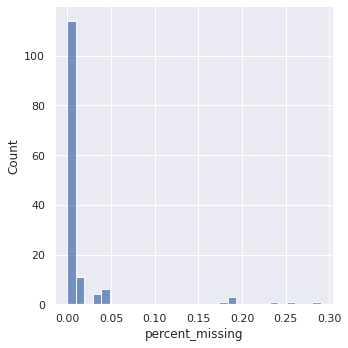

In [14]:
import seaborn as sns

missing_value_df = missing_value_df_copy[missing_value_df_copy['percent_missing'] < 0.3]

sns.set_theme()
sns.displot(missing_value_df, x='percent_missing', bins=30)

In [15]:
# Filter main df by removing columns with too many missing values
print(df.shape)
filtered_columns = missing_value_df['column_name'].to_numpy()
df = df[filtered_columns]
print(df.shape)

(990, 206)
(990, 142)


In [16]:
# Store how many missing values has the row before imputation to check for later outliers
missing_track = df.apply(lambda x: x.isna().sum(), axis=1)
missing_track.describe()

count    990.000000
mean       2.135354
std        2.424150
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       31.000000
dtype: float64

In [17]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer()
simple_data = copy(df.select_dtypes(include='number'))
simple_data[:] = simple_imputer.fit_transform(simple_data)

Check that the imputation does not modify the distributions of data:

In [18]:
from scipy.stats import ks_2samp

def check_distributions(df1, df2, printit=True, badcols=False):
    
    pvalue = 0
    n = 0
    bad_cols = []
    for col in df2.columns:
        ks = ks_2samp(df1[col].dropna(), df2[col])
        pvalue += ks.pvalue
        
        if ks.pvalue < 0.05: 
            n += 1 
            if printit: 
                bad_cols.append(col)
                print(col, df1[col].isna().sum())
    
    avg_pvalue = pvalue/len(df1.columns)
    if badcols:
        return bad_cols
    return avg_pvalue, n

check_distributions(df.select_dtypes(include='number'), simple_data, printit=False)

(0.9447816708186425, 7)

In [19]:
for k in range(1,10):
    knn_imputer = KNNImputer(n_neighbors=k, weights='distance')
    knn_data = copy(df.select_dtypes(include='number'))
    knn_data[:] = knn_imputer.fit_transform(knn_data)
    print(f'K: {k}', check_distributions(df.select_dtypes(include='number'), knn_data, printit=False))

K: 1 (0.9705740519550266, 2)
K: 2 (0.9661327495741395, 2)
K: 3 (0.9623349735134973, 4)
K: 4 (0.9587438818731353, 4)
K: 5 (0.957354850001677, 4)
K: 6 (0.9564083339567502, 4)
K: 7 (0.9545587802152773, 4)
K: 8 (0.9531440345888285, 5)
K: 9 (0.9525929408188508, 5)


In [20]:
# Best imputer
knn_imputer = KNNImputer(n_neighbors=2, weights='distance')
imputed_data = copy(df.select_dtypes(include='number'))
imputed_data[:] = knn_imputer.fit_transform(imputed_data)
bad_cols = check_distributions(df.select_dtypes(include='number'), imputed_data, badcols=True)

elections_municipal_elections_electors 186
quality_of_life_type_of_dwellings_secondary 237


In [21]:
df.loc[:, imputed_data.columns] = imputed_data
df.drop(columns=bad_cols, inplace=True)

## Categorical Missing Values

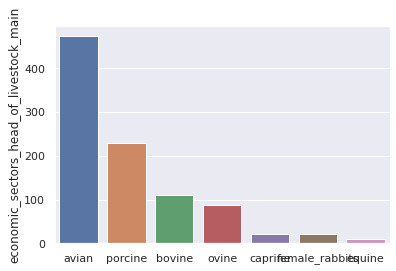

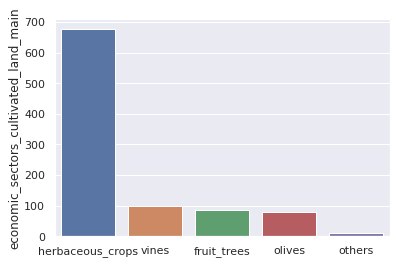

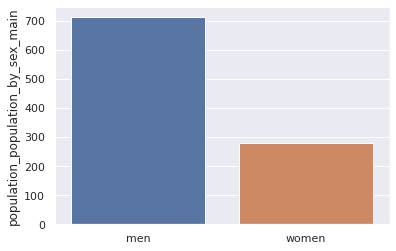

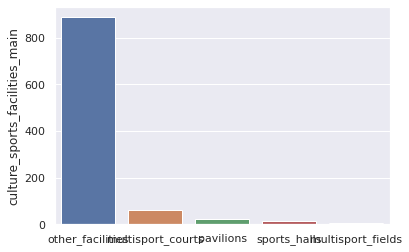

In [22]:
import matplotlib.pyplot as plt

for cat in df.select_dtypes(exclude='number').columns:
    aux = df[cat].value_counts()
    sns.barplot(x=aux.index, y=aux)
    plt.show()

In [23]:
df.select_dtypes(exclude='number').isna().sum()

economic_sectors_head_of_livestock_main    38
economic_sectors_cultivated_land_main      38
population_population_by_sex_main           0
culture_sports_facilities_main              0
dtype: int64

In [24]:
df = df.apply(lambda x: x.fillna('Unknown'))

In [25]:
df['missing_count'] = missing_track

## Outliers - Mahalanobis Distance

In [26]:
import numpy as np

num_df = copy(df.select_dtypes(include='number'))
covariance = np.cov(num_df, rowvar=False)
sum(sum(pd.isna(covariance))) # Issues with covariance due to high correlations

0

In [27]:
covariance_pm1 = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(num_df, axis=0)

In [28]:
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

distances = []
for i in range(len(num_df)):
      p1 = num_df.iloc[i,:]
      p2 = centerpoint
      # distance = mahalanobis(p1, p2, covariance_pm1)
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.99, num_df.shape[1])

# # Index of outliers
outlierIndexes = np.where(distances > cutoff )

print('--- Index of Outliers ----')
print(len(outlierIndexes[0]))

--- Index of Outliers ----
227


## Model Based

In [29]:
from sklearn.ensemble import IsolationForest

num_df = copy(df.select_dtypes(include='number'))

#create the method instance
isf = IsolationForest(n_estimators = 100, random_state = 42, contamination = 'auto')

#use fit_predict on the data as we are using all the data
preds = isf.fit_predict(num_df)

# #extract outliers from the data
num_df["iso_forest_outliers"] = preds
num_df["iso_forest_outliers"] = num_df["iso_forest_outliers"].astype(str)

print(num_df.shape[1])

# #extract the scores from the data in terms of strength of outlier
num_df["iso_forest_scores"] = isf.decision_function(num_df.drop(columns='iso_forest_outliers')) #print how many outliers the data suggests
print(num_df["iso_forest_outliers"].value_counts())

138
1     971
-1     19
Name: iso_forest_outliers, dtype: int64


In [30]:
outlier_ix = num_df[num_df['iso_forest_outliers'] == '-1'].index
nonoutlier_ix = num_df[num_df['iso_forest_outliers'] == '1'].index
num_df.loc[outlier_ix, 'missing_count'].describe()

count    19.000000
mean      8.105263
std       4.875047
min       2.000000
25%       4.000000
50%       8.000000
75%      10.000000
max      19.000000
Name: missing_count, dtype: float64

In [31]:
num_df.loc[nonoutlier_ix, 'missing_count'].describe()

count    971.000000
mean       2.018538
std        2.199734
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       31.000000
Name: missing_count, dtype: float64

In [32]:
clean_data = df.loc[nonoutlier_ix, :]
outlier_data = df.loc[outlier_ix, :]

clean_data.to_csv('../data/clean_data.csv')
outlier_data.to_csv('../data/outlier_data.csv')

---

## Categorical Label

The distribution of the label looks as follows:

In [43]:
import pandas as pd

df = pd.read_csv('../data/clean_data.csv')
label = df['culture_knowledge_of_catalan_total'].to_frame()

In [34]:
labels = df.filter(like='catalan')
labels

,culture_knowledge_of_catalan_understand,culture_knowledge_of_catalan_speak,culture_knowledge_of_catalan_read,culture_knowledge_of_catalan_write,culture_knowledge_of_catalan_total
Municipality,,,,,
Alt Camp,42677.0,36667.0,37514.0,28027.0,43648.0
Alt Empordà,127128.0,97018.0,103691.0,74454.0,135142.0
Alt Penedès,98905.0,83190.0,85661.0,64215.0,101916.0
Alt Urgell,20245.0,17547.0,18286.0,13328.0,20605.0
Alta Ribagorça,3997.0,3248.0,3377.0,2418.0,4032.0
...,...,...,...,...,...
Camarles,3434.0,2994.0,3020.0,2096.0,3476.0
"Aldea, l'",4231.0,3309.0,3436.0,2444.0,4371.0
Salou,23702.0,14934.0,18184.0,11517.0,25804.0


Since the label is quite important we will normalize it using data from the same year it was measured, 2011:

In [57]:
aux = pd.read_csv(os.path.join(data_path, 'pmh446mun.csv'))
aux = aux[aux['year'] == 2011]
aux = aux[aux['sex'] == 'total']
print(aux.shape)
aux.head()

(948, 6)


,year,municipalities,sex,concept,status,value
36974,2011,Abella de la Conca,total,population,NaN,181.0
36977,2011,Abrera,total,population,NaN,11611.0
36980,2011,Àger,total,population,NaN,590.0
36983,2011,Agramunt,total,population,NaN,5653.0
36986,2011,Aguilar de Segarra,total,population,NaN,245.0


In [45]:
df.head()

,Municipality,territory__altitude,territory__longitude,territory__latitude,territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,population_density_of_population_density_density,population_population_by_sex_total,population_population_by_age_groups_from_0_to_14_years,population_population_by_age_groups_from_15_to_64_years,...,economic_sectors_fleet_of_vehicles_total,environment_municipal_waste_generation_per_capita,environment_municipal_waste_selective_collection,environment_industrial_waste_establishments_with_yearly_waste_declarations,environment_industrial_waste_industrial_waste,economic_sectors_head_of_livestock_main,economic_sectors_cultivated_land_main,population_population_by_sex_main,culture_sports_facilities_main,missing_count
0,Alt Camp,16.079099,2.023157,41.340327,418264.757486,4.577078e+06,83.7,45045.0,0.151671,0.656033,...,0.866533,1.42,46.3,0.004174,2.517743,avian,vines,men,other_facilities,5
1,Alt Empordà,125.805903,0.836036,41.450831,319330.559124,4.591190e+06,105.9,143762.0,0.155493,0.657211,...,0.892357,2.23,50.7,0.002045,0.150424,avian,herbaceous_crops,men,other_facilities,5
2,Alt Penedès,100.990555,1.692342,41.437807,390340.606035,4.588583e+06,185.9,110172.0,0.163717,0.658216,...,0.846613,1.57,46.6,0.005056,1.419879,avian,vines,women,other_facilities,5
3,Alt Urgell,83.858890,1.127585,41.061413,342331.611396,4.547538e+06,14.1,20453.0,0.130397,0.653058,...,0.908131,1.38,51.5,0.002005,0.137021,avian,herbaceous_crops,women,other_facilities,5
4,Alta Ribagorça,149.616919,2.893855,41.844447,491139.554229,4.632644e+06,9.2,3945.0,0.125475,0.669962,...,0.844867,1.57,50.0,0.004056,0.097336,ovine,herbaceous_crops,men,other_facilities,6


In [58]:
d = pd.merge(aux, df, left_on='municipalities', right_on='Municipality')

In [59]:
d[['municipalities', 'Municipality']]

,municipalities,Municipality
0,Abella de la Conca,Abella de la Conca
1,Abrera,Abrera
2,Àger,Àger
3,Agramunt,Agramunt
4,Aguilar de Segarra,Aguilar de Segarra
...,...,...
924,Vinebre,Vinebre
925,Vinyols i els Arcs,Vinyols i els Arcs
926,Viver i Serrateix,Viver i Serrateix
927,Xerta,Xerta


In [110]:
labels.describe()

,culture_knowledge_of_catalan_understand,culture_knowledge_of_catalan_speak,culture_knowledge_of_catalan_read,culture_knowledge_of_catalan_write,culture_knowledge_of_catalan_total
count,964.000000,964.000000,964.000000,964.000000,964.000000
mean,0.948326,0.827285,0.841200,0.625976,0.970364
std,0.100555,0.127951,0.114640,0.104263,0.095539
min,0.345603,0.296524,0.304703,0.208589,0.349693
25%,0.878796,0.738803,0.762370,0.557494,0.907767
50%,0.932025,0.823278,0.831430,0.622966,0.957460
75%,1.006219,0.912152,0.911659,0.687855,1.020918
max,1.390000,1.260000,1.370000,1.021739,1.390000


## Visualizations

In [3]:
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
df.drop('missing_count', axis=1, inplace=True)

In [5]:
min_val = df['culture_knowledge_of_catalan_total'].min()
max_val = df['culture_knowledge_of_catalan_total'].max()

In [6]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
cmap = matplotlib.cm.get_cmap('Spectral')

In [10]:
shp_path = '../plots/municipalities_map/divisions-administratives-v2r0-municipis-5000-20210701.shp'
sf = shp.Reader(shp_path)

In [26]:
sf.records()[1]

Record #1: ['080023', 'Aguilar de Segarra', 43.2198, '07', 'Bages', 'Manresa', '07', 'Catalunya Central', '*', '08', 'Barcelona', 'Barcelona']

In [11]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (16,12), data=None):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    
    # Values
    min_val = data['culture_knowledge_of_catalan_total'].min()
    max_val = data['culture_knowledge_of_catalan_total'].max()
    norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
    cmap = matplotlib.cm.get_cmap('Spectral')
    
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
        try:
            # Fill
            record = sf.records()[id]
            gid = int(record[0])
            value = df.loc[gid, 'culture_knowledge_of_catalan_total']
            rgba = cmap(norm(value))
            ax.fill(x, y, color=rgba)
            
            # shape_ex = sf.shape(id)
            # x_lon = np.zeros((len(shape_ex.points),1))
            # y_lat = np.zeros((len(shape_ex.points),1))
            # for ip in range(len(shape_ex.points)):
            #     x_lon[ip] = shape_ex.points[ip][0]
            #     y_lat[ip] = shape_ex.points[ip][1]
            # ax.fill(x_lon,y_lat, color)
        except:
            pass
        
        id = id+1
        
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

<Figure size 1152x864 with 0 Axes>

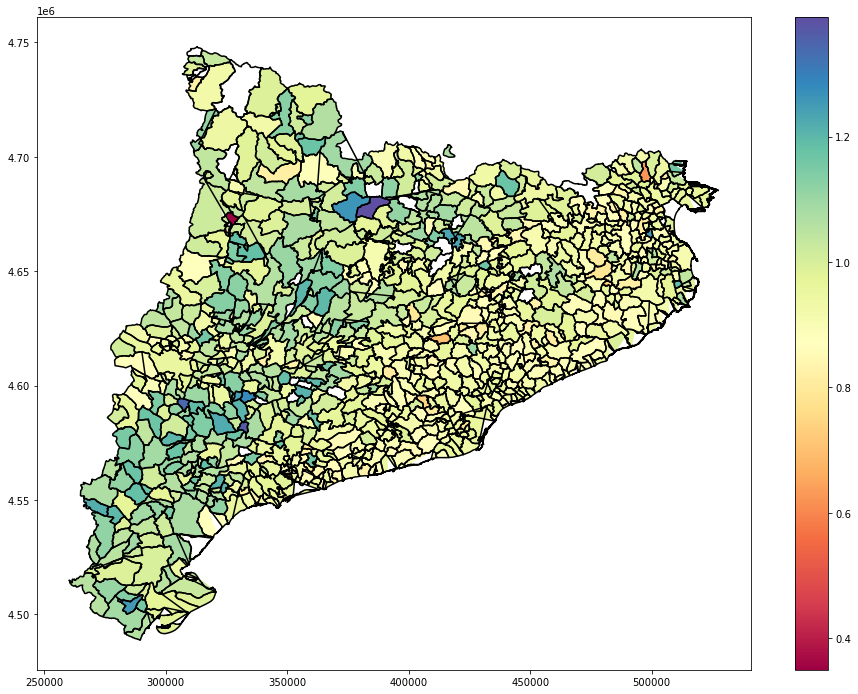

In [12]:
plot_map(sf, data=df)